In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from pathlib import Path
from scipy.special import rel_entr, kl_div
from scipy.stats import wasserstein_distance

PARAMETERS = ['cpa', 'pwr1par', 'pwr2par', 'pwr1perr', 'pwr2perr'] 
PARAMETERS_MIN = np.array([100., 0.4, 0.4, 0.4, 0.4]) 
PARAMETERS_MAX = np.array([870., 1.7, 1.7, 2.3, 2.3]) 

## Relevant functions from utils.py
Can't just import utils since path to data is different than utils.py

In [2]:
def index_mcmc_runs(file_version):
    """Make a list of combinations for which we want to run MCMC."""
    if file_version == '2023':
        experiments = ['AMS02_H-PRL2021', 'PAMELA_H-ApJ2013', 'PAMELA_H-ApJL2018']
        dfs = []
        for experiment_name in experiments:
            filename = f'../../data/2023/{experiment_name}_heliosphere.dat'
            df = index_experiment_files(filename) 
            df['experiment_name'] = experiment_name
            df['filename_heliosphere'] = filename
            dfs.append(df)
        df = pd.concat(dfs, axis=0, ignore_index=0)

    elif file_version == '2024':
        filename = f'../../data/2024/yearly_heliosphere.dat'
        df = read_experiment_summary(filename)
        df['experiment_name'] = 'yearly'
        df['filename_heliosphere'] = filename

    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    return df

def read_experiment_summary(filename) -> pd.DataFrame:
    """
    Read .dat filename that describes experimental conditions during time intervals.
    """
    if '2023' in filename: file_version = '2023'
    elif '2024' in filename: file_version = '2024'
    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    if file_version == '2023':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std"
        df = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std'])
    
        # Parse interval
        df['beginning'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))
        df['ending'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))

    elif file_version == '2024':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std; polarity"
        df_full = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std', 'polarity'])

        # only use the neg or neg,pos polarities column, and change all to be neg
        df = df_full[df_full['polarity'].str.contains('neg')].copy(deep=True)
        df['polarity'] = 'neg'

    return df

def index_experiment_files(filename)->pd.DataFrame:
    """Create list of experiments that need to be done. 
    Note this is only needed for file_version '2023'
    filename = f'../../data/2023/{EXPERIMENT_NAME}_heliosphere.dat'
    """
    df = read_experiment_summary(filename)
    # The datasets to be fitted are: PAMELA_H-ApJ2013, PAMELA_H-ApJL2018, and AMS02_H-PRL2021.
    # You should use the neg models for data files up to February 2015, and the pos models for data files from October 2013.
    # So, between October 2013 and February 2015, the data files should be fitted independently with both neg and pos models.
    # All PAMELA files are before February 2015, so only neg models for them.
    # For AMS02 files, 20130925-20131021.dat is the first file to be fitted with pos models, while 20150124-20150219.dat is the last file to be fitted with neg models.
    # 
    # For PAMELA_H-ApJL2018, the files 20130928-20131025.dat, 20131121-20131219.dat, and 20140115-20140211.dat should be fit independently with both neg and pos models.

    dfneg = df[df.beginning < pd.to_datetime('March 1 2015')].copy(deep=True)
    dfneg['polarity'] = 'neg'

    dfpos = df[df.ending >= pd.to_datetime('October 1 2013')].copy(deep=True)
    dfpos['polarity'] = 'pos'

    # rval = pd.concat([dfneg, dfpos], axis=0, ignore_index=True)
    rval = dfneg # Only fitting negative models for now.
    
    return rval

Implement distance metrics, including Gelman-Rubin statistic

In [3]:
def _as_array(x):
    """Get a float64 NumPy array from a pandas Series/array-like."""
    # Works for pandas Series (has .values) and plain np arrays/lists
    try:
        return np.asarray(x.values, dtype=float)
    except AttributeError:
        return np.asarray(x, dtype=float)

def _rhat_from_chains(chains_2d: np.ndarray,
                      ensure_ge1: bool = True,
                      return_details: bool = False):
    """
    Compute Gelman–Rubin R-hat from multiple chains following the 4-step description from 
    https://mystatisticsblog.blogspot.com/2019/04/gelman-rubin-convergence-criteria-for.html. 
    Assumes chains are already prepared (e.g., only second halves if that's your convention), 
    so that `chains_2d` has shape (m, n) with m = #chains and n = samples/chain.

    Steps implemented:
      1) (Warmup removal is assumed done before this function.)
      2) Per-chain mean & variance:  θ̄_j and σ²(θ_j)
      3) Mean-of-means θ̄̄, mean within-chain variance σ̄²(θ),
         variance of chain means σ²(θ̄)
         Then B_j = σ²(θ̄) − (1/n) σ̄²(θ)
      4) R̂ = sqrt( 1 + B_j / σ̄²(θ) )

    Also computes the classic equivalent:
      W = σ̄²(θ), B = n * σ²(θ̄),
      Var⁺ = ((n−1)/n) W + (B/n),
      R̂_classic = sqrt(Var⁺ / W)

    Args
    ----
    chains_2d : np.ndarray
        Shape (m, n): m chains, n samples per chain.
    ensure_ge1 : bool
        If True, clamp R-hat to be at least 1.0 (common practice).
    return_details : bool
        If True, return (rhat, details_dict). Otherwise return rhat (float).

    Returns
    -------
    rhat : float
    (optionally) details : dict with intermediate quantities
    """
    if chains_2d.ndim != 2:
        raise ValueError("chains_2d must have shape (m, n).")
    m, n = chains_2d.shape
    if m < 2 or n < 2:
        out = np.nan
        return (out, {}) if return_details else out

    # Step 2: per-chain means and variances (unbiased)
    theta_bar_j = chains_2d.mean(axis=1)             # θ̄_j
    sigma2_theta_j = chains_2d.var(axis=1, ddof=1)   # σ²(θ_j), unbiased

    # Step 3: across-chain aggregates
    theta_barbar = theta_bar_j.mean()                              # θ̄̄
    sigma2_bar_theta = sigma2_theta_j.mean()                       # σ̄²(θ) = W
    sigma2_theta_bar = theta_bar_j.var(ddof=1)                     # σ²(θ̄)
    B_j = sigma2_theta_bar - (sigma2_bar_theta / n)                # B_j

    # Step 4: scale reduction
    if sigma2_bar_theta <= 0:
        rhat = np.nan
    else:
        rhat = float(np.sqrt(1.0 + (B_j / sigma2_bar_theta)))

    # Optional clamp to ≥ 1
    if ensure_ge1 and np.isfinite(rhat):
        if rhat < 1.0:
            rhat = 1.0

    # Classic form (for verification / curiosity)
    W = sigma2_bar_theta
    B = n * sigma2_theta_bar
    var_plus = ((n - 1) / n) * W + (B / n)
    rhat_classic = float(np.sqrt(var_plus / W)) if W > 0 else np.nan

    if return_details:
        details = {
            "m": m, "n": n,
            "theta_bar_j": theta_bar_j,          # per-chain means
            "sigma2_theta_j": sigma2_theta_j,    # per-chain variances
            "theta_barbar": theta_barbar,        # mean of means
            "sigma2_bar_theta": sigma2_bar_theta,# mean within-chain var (W)
            "sigma2_theta_bar": sigma2_theta_bar,# variance of chain means
            "B_j": B_j,
            "W": W, "B": B, "var_plus": var_plus,
            "rhat_equation_form": rhat,
            "rhat_classic_equivalent": rhat_classic
        }
        return rhat, details
    else:
        return rhat

def compute_rhat(
    chains_samples,
    params=PARAMETERS,
    mode: str = "split",   # "split" or "last_half"
    thin: int = 1,
    return_details: bool = False
):
    """
    Compute R-hat for each parameter across multiple HMC chains.

    Args:
      chains_samples: list of dict[param -> pd.Series/np.ndarray]
      params: list of parameter names to compute.
      mode:
        - "split": split each chain into two halves → shape (2*#chains, N/2)
        - "last_half": keep only the second half of each chain → shape (#chains, N/2)
      thin: keep every 'thin'-th sample (applied after halving/splitting prep)

    Returns:
      dict[param -> rhat_value]
    """
    assert mode in {"split", "last_half"}, "mode must be 'split' or 'last_half'"
    rhats = {}

    for p in params:
        segments = []  # list of 1D arrays to be stacked into (m, n)

        # Build per-chain segments according to the selected mode
        for ch in chains_samples:
            if p not in ch:
                continue
            x = _as_array(ch[p])
            if x.size < 4:
                continue  # too short to halve/split sensibly

            n = x.size
            half = n // 2

            if mode == "last_half":
                seg = x[half:]              # keep only the second half
                seg = seg[::thin]           # thin
                if seg.size >= 2:
                    segments.append(seg)

            elif mode == "split":
                first = x[:half]
                second = x[-half:]
                first = first[::thin]
                second = second[::thin]
                if first.size >= 2:
                    segments.append(first)
                if second.size >= 2:
                    segments.append(second)

        # Need at least 2 (sub)chains total
        if len(segments) < 2:
            rhats[p] = np.nan
            continue

        # Align lengths across segments
        segment_lengths = [len(s) for s in segments]
        n_min = np.min(segment_lengths)
        if n_min < 2:
            rhats[p] = np.nan
            continue

        chains_2d = np.stack([s[:n_min] for s in segments])  # shape (m, n_min)
        rhats[p] = _rhat_from_chains(chains_2d, return_details=return_details)

    return rhats

def get_distance(hist_0, hist_1, metric='mae'):
    """
    Compute distance between two histograms.
    """
    num_bins = len(hist_0)
    if len(hist_1) != num_bins:
        raise ValueError(f"Histograms must have the same number of bins. {len(hist_0)} != {len(hist_1)}")
    
    if metric == 'mae':
        return np.abs(hist_0 - hist_1).sum() / num_bins
    elif metric == 'mse':
        return ((hist_0 - hist_1) ** 2).sum() / num_bins
    elif metric == 'kl':
        return kl_div(hist_0, hist_1).sum()
    elif metric == 'wasserstein':
        return wasserstein_distance(hist_0, hist_1)
    else:
        raise ValueError(f"Unknown metric {metric}.")

## Individual run

Interval 20140306-20140401 corresponds to index 38 for neg polarity in AMS02_H-PRL2021.


/home/linneamw/anaconda3/envs/gcr-gpu/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


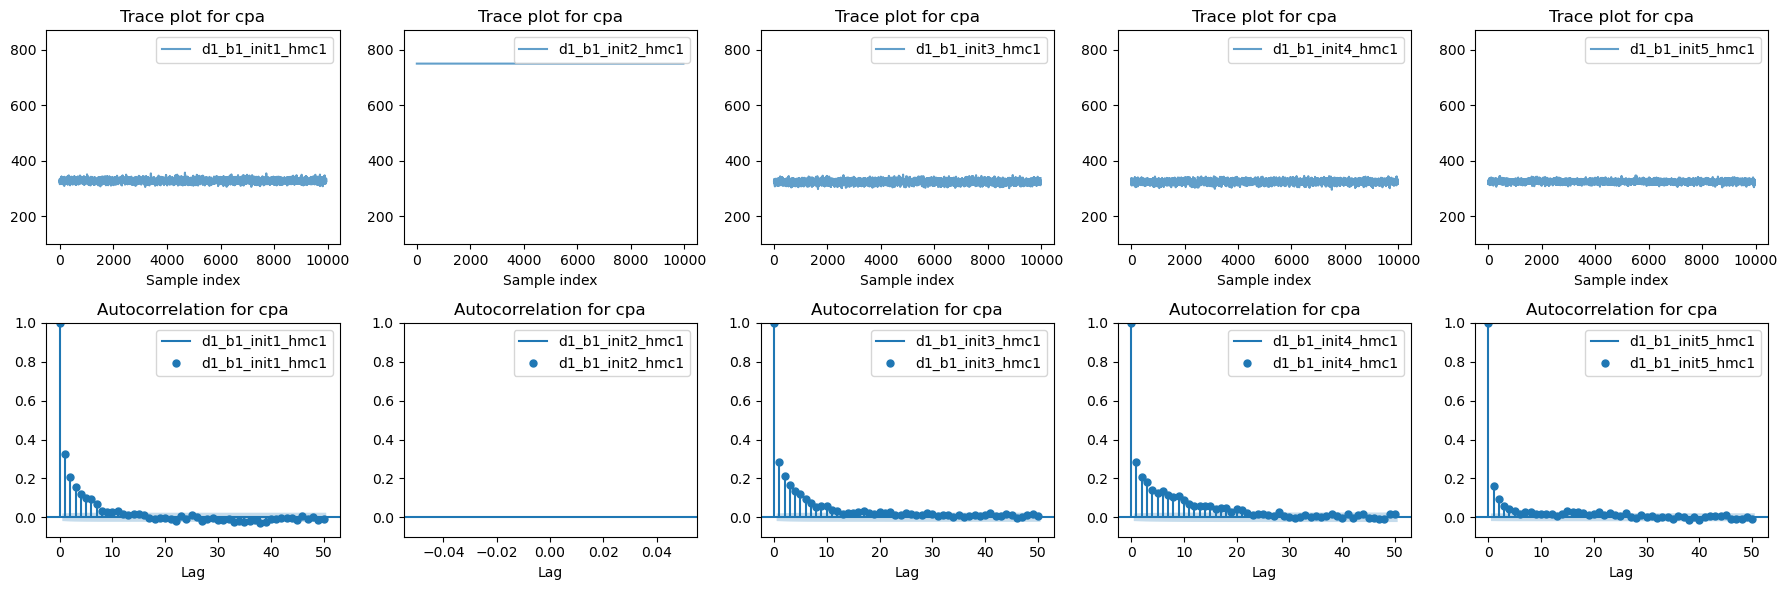

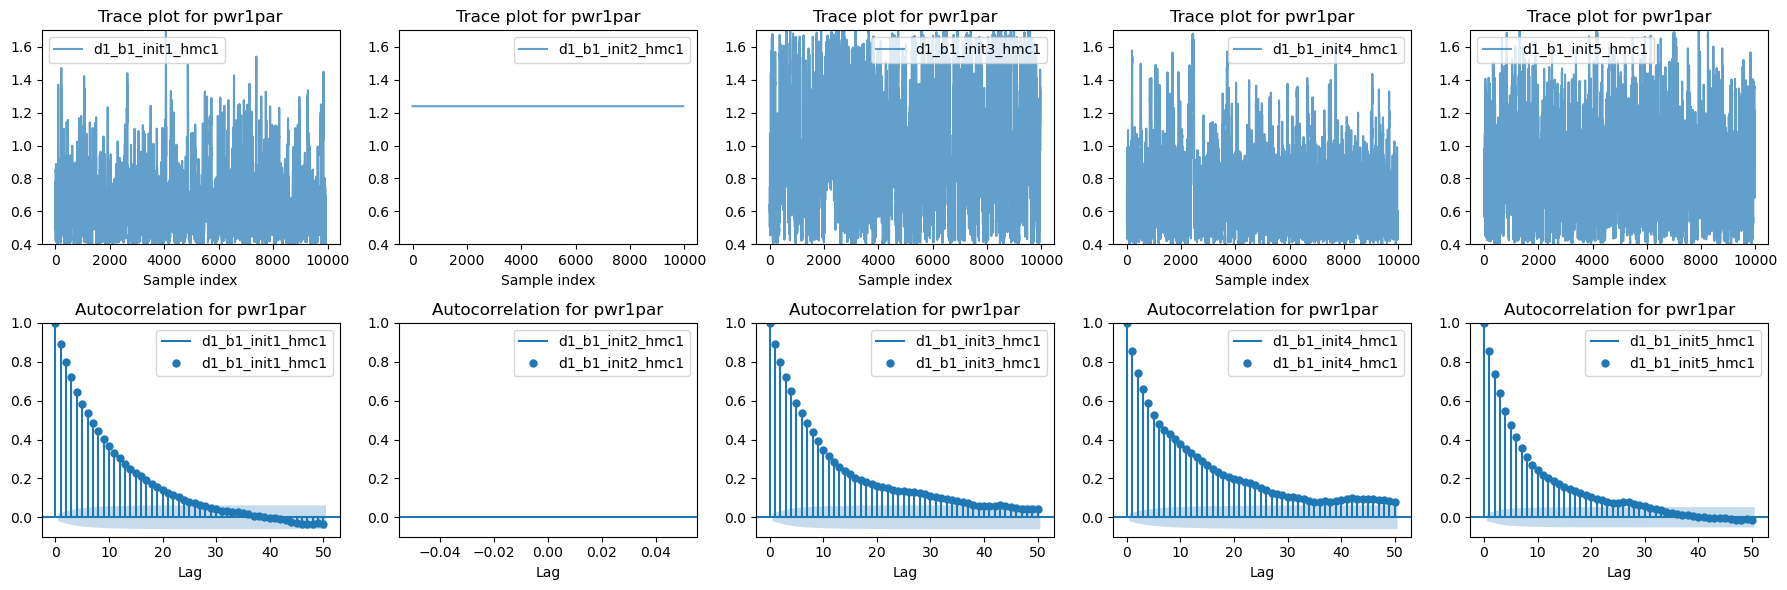

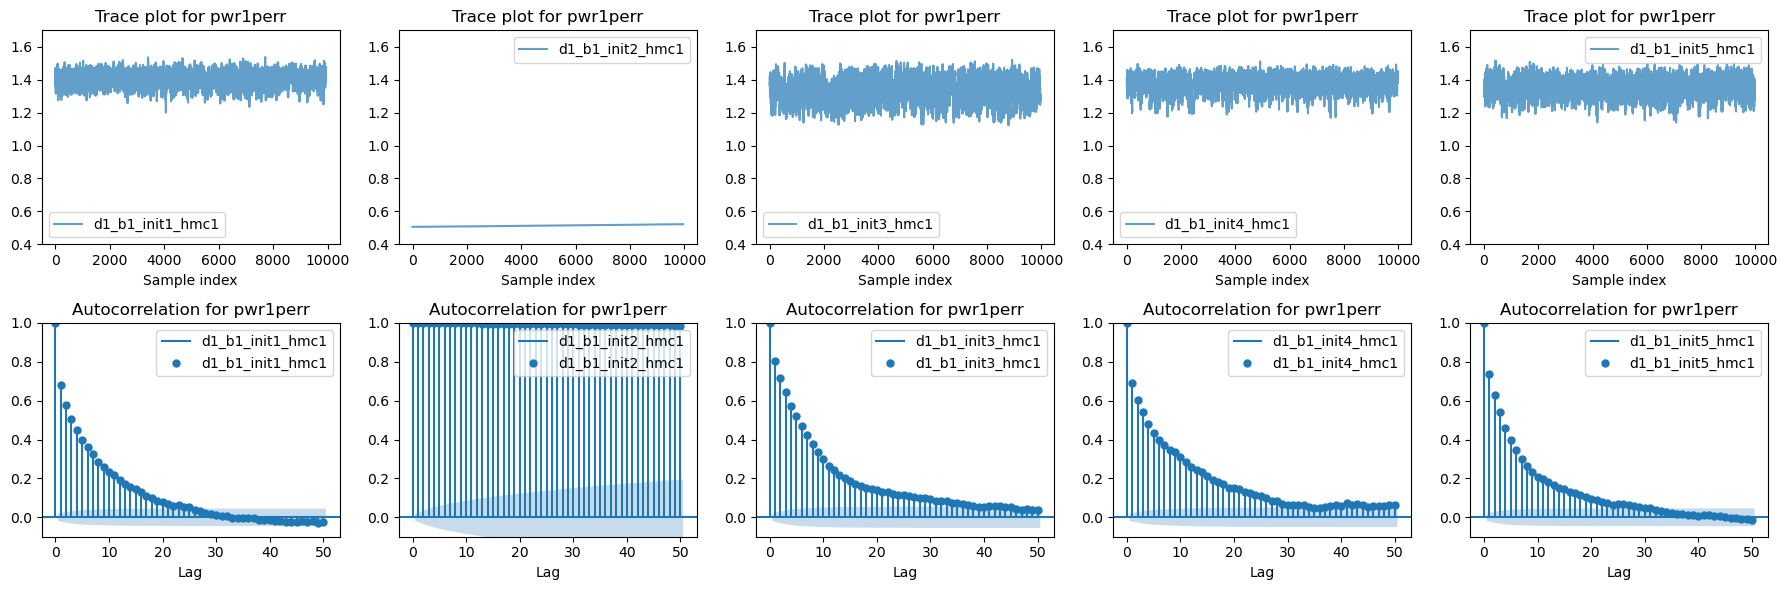

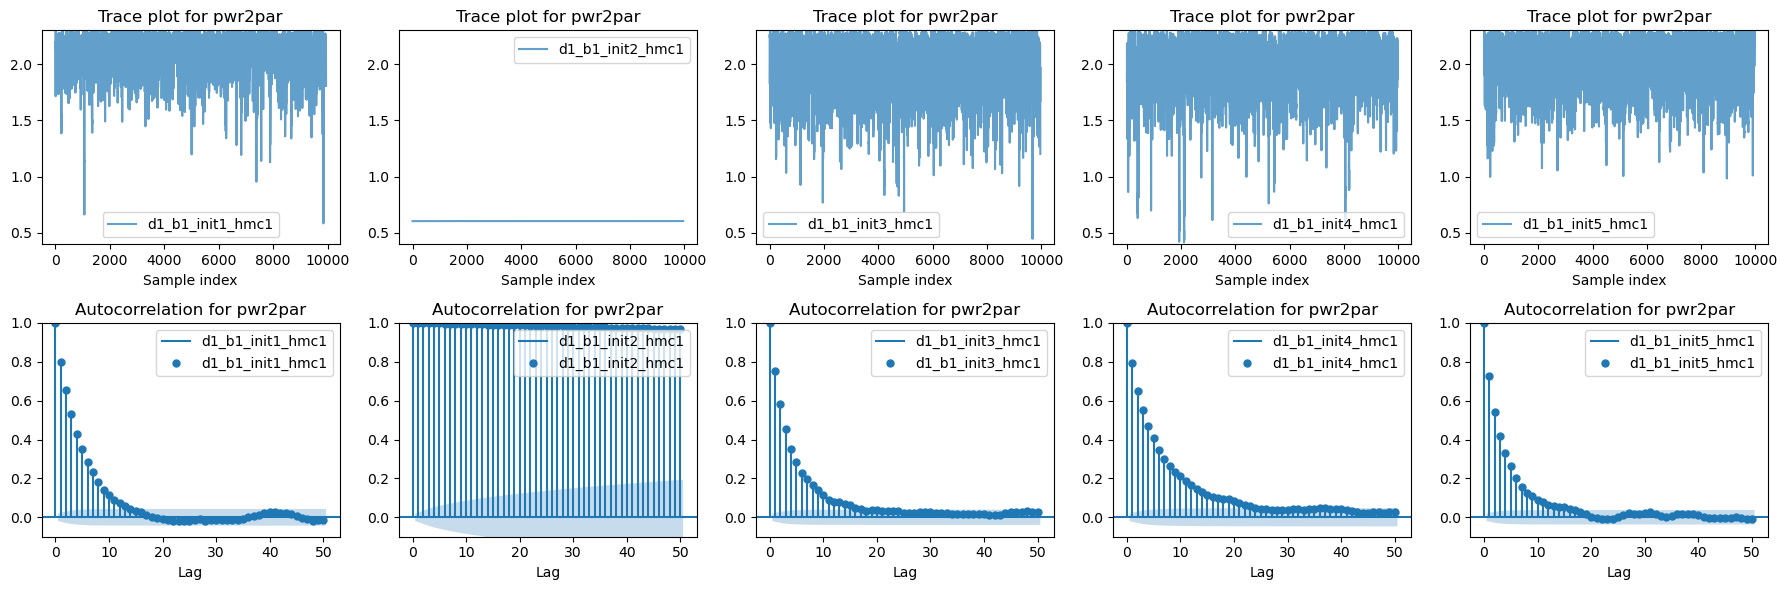

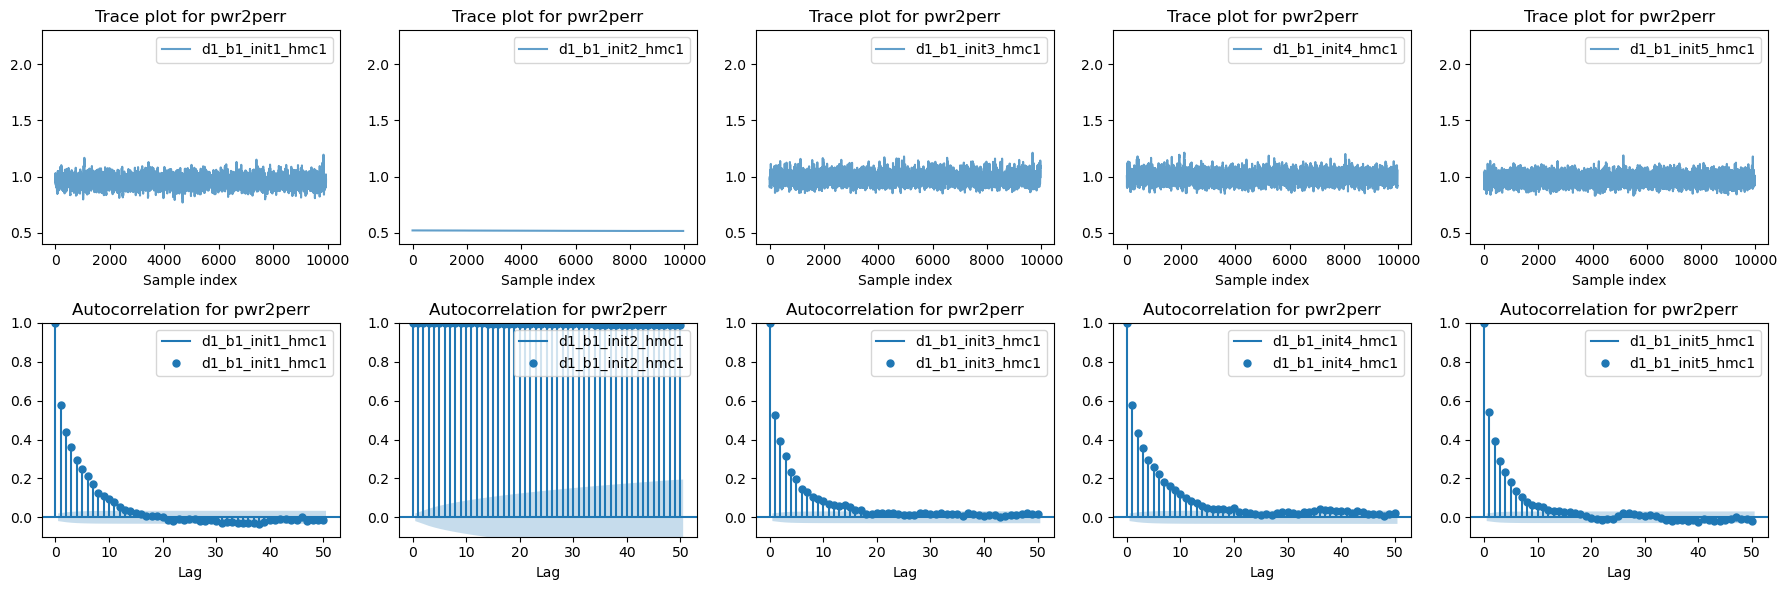

In [4]:
data_version=['d1', 'd2', 'd3', 'd4', 'd5'] 
model_version=['init1', 'init2', 'init3', 'init4', 'init5'] 
hmc_run = ['hmc1', 'hmc2', 'hmc3', 'hmc4', 'hmc5']
bootstrap=['b0', 'b1'] # 'b0' or 'b1', false or true

# Parameters (change me!)
which_change = "model_init" # 'bootstrapped_data', 'model_init', 'hmc_init'
idx = 38 # 24 corresponds to 20130221-20130319, the interval in the original paper
train_size_fraction = 0.8
hmc_version='v34_trial5_full'
if which_change == "bootstrapped_data":
    data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_1 = f"{data_version[1]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_2 = f"{data_version[2]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_3 = f"{data_version[3]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_4 = f"{data_version[4]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
elif which_change == "model_init":
    data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_1 = f"{data_version[0]}_{bootstrap[1]}_{model_version[1]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_2 = f"{data_version[0]}_{bootstrap[1]}_{model_version[2]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_3 = f"{data_version[0]}_{bootstrap[1]}_{model_version[3]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_4 = f"{data_version[0]}_{bootstrap[1]}_{model_version[4]}_{hmc_run[0]}"
elif which_change == "hmc_init":
    data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_1 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[1]}"
    data_bootstrap_model_hmc_identifier_2 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[2]}"
    data_bootstrap_model_hmc_identifier_3 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[3]}"
    data_bootstrap_model_hmc_identifier_4 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[4]}"
else: # Change me manually!
    data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_1 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_2 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_3 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
    data_bootstrap_model_hmc_identifier_4 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"


# Load relevant HMC results
results_dir_hmc_0 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_0}_{train_size_fraction}/"
results_dir_hmc_1 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}/"
results_dir_hmc_2 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_2}_{train_size_fraction}/"
results_dir_hmc_3 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_3}_{train_size_fraction}/"
results_dir_hmc_4 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_4}_{train_size_fraction}/"

# Make plots folder if it doesn't exist
plots_dir = Path(f'../../../results/{hmc_version}/plots/{which_change}/{train_size_fraction}/')
plots_dir.mkdir(parents=True, exist_ok=True)

# Get interval corresponding to one in paper
df = index_mcmc_runs(file_version='2023')
df_int = df.iloc[idx:idx+1].copy(deep=True)
interval = df_int.interval.iloc[0]
polarity = df_int.polarity.iloc[0]
exp_name = df_int.experiment_name.iloc[0]
print(f"Interval {interval} corresponds to index {idx} for {polarity} polarity in {exp_name}.")
df_int.head()

# Load the samples from each hmc run
# They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
# csv file has no headers, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
hmc_0_samples = pd.read_csv(f'{results_dir_hmc_0}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
hmc_1_samples = pd.read_csv(f'{results_dir_hmc_1}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
hmc_2_samples = pd.read_csv(f'{results_dir_hmc_2}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
hmc_3_samples = pd.read_csv(f'{results_dir_hmc_3}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
hmc_4_samples = pd.read_csv(f'{results_dir_hmc_4}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')

PARAMETERS = ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
hmc_0_samples.columns = PARAMETERS
hmc_1_samples.columns = PARAMETERS
hmc_2_samples.columns = PARAMETERS
hmc_3_samples.columns = PARAMETERS
hmc_4_samples.columns = PARAMETERS

# For each parameter, plot the trace and the autocorrelation function for each HMC run
for param in PARAMETERS:
    fig, axs = plt.subplots(2, 5, figsize=(18, 6))
    axs[0][0].plot(hmc_0_samples[param], label=f'{data_bootstrap_model_hmc_identifier_0}', alpha=0.7)
    axs[0][1].plot(hmc_1_samples[param], label=f'{data_bootstrap_model_hmc_identifier_1}', alpha=0.7)
    axs[0][2].plot(hmc_2_samples[param], label=f'{data_bootstrap_model_hmc_identifier_2}', alpha=0.7)
    axs[0][3].plot(hmc_3_samples[param], label=f'{data_bootstrap_model_hmc_identifier_3}', alpha=0.7)
    axs[0][4].plot(hmc_4_samples[param], label=f'{data_bootstrap_model_hmc_identifier_4}', alpha=0.7)
    for ax in axs[0]:
        ax.set_title(f'Trace plot for {param}')
        ax.set_xlabel('Sample index')
        ax.set_ylim(PARAMETERS_MIN[PARAMETERS.index(param)], PARAMETERS_MAX[PARAMETERS.index(param)])
        ax.legend()
    
    plot_acf(hmc_0_samples[param], ax=axs[1][0], lags=50, title=f'Autocorrelation for {param}', label=f'{data_bootstrap_model_hmc_identifier_0}')
    plot_acf(hmc_1_samples[param], ax=axs[1][1], lags=50, title=f'Autocorrelation for {param}', label=f'{data_bootstrap_model_hmc_identifier_1}')
    plot_acf(hmc_2_samples[param], ax=axs[1][2], lags=50, title=f'Autocorrelation for {param}', label=f'{data_bootstrap_model_hmc_identifier_2}')
    plot_acf(hmc_3_samples[param], ax=axs[1][3], lags=50, title=f'Autocorrelation for {param}', label=f'{data_bootstrap_model_hmc_identifier_3}')
    plot_acf(hmc_4_samples[param], ax=axs[1][4], lags=50, title=f'Autocorrelation for {param}', label=f'{data_bootstrap_model_hmc_identifier_4}')
    for ax in axs[1]:
        ax.set_xlabel('Lag')
        ax.set_ylim(-0.1, 1.0)
        ax.legend()

    plt.tight_layout()
    plt.savefig(plots_dir / f'trace_acf_{param}_{polarity}_{idx}.png')
    plt.show()

In [5]:
# Calculate Gelman-Rubin R-hat statistic for each parameter
chains_samples = [hmc_0_samples, hmc_1_samples , hmc_2_samples, hmc_3_samples, hmc_4_samples]
rhats = compute_rhat(chains_samples, params=PARAMETERS, mode='split', thin=1, return_details=True)
print(rhats)
print("R-hat statistics:")
for param, rhat in rhats.items():
    if isinstance(rhat, tuple):
        rhat_value, details = rhat
        print(f"  {param}: {rhat_value:.4f} (details: m={details['m']}, n={details['n']}, rhat_classic={details['rhat_classic_equivalent']:.4f})")
    else:
        print(f"  {param}: {rhat:.4f}")

{'cpa': (31.384949891591983, {'m': 10, 'n': 4969, 'theta_bar_j': array([328.5738357 , 328.45657556, 750.19464111, 750.19464111,
       324.13351003, 324.19286094, 324.73824888, 324.74139659,
       325.45693496, 325.3627821 ]), 'sigma2_theta_j': array([44.73413607, 43.2153799 ,  0.        ,  0.        , 47.66988621,
       46.60930493, 45.33502142, 41.22508927, 27.91341505, 28.86428611]), 'theta_barbar': 410.60454269903573, 'sigma2_bar_theta': 32.55665189389412, 'sigma2_theta_bar': 32036.24296001427, 'B_j': 32036.236408061788, 'W': 32.55665189389412, 'B': 159188091.2683109, 'var_plus': 32068.79305995568, 'rhat_equation_form': 31.384949891591983, 'rhat_classic_equivalent': 31.38494989159198}), 'pwr1par': (1.3357490784526311, {'m': 10, 'n': 4969, 'theta_bar_j': array([0.63560397, 0.66214679, 1.23860121, 1.23860121, 0.97884323,
       0.98357384, 0.72709932, 0.69255076, 0.85966993, 0.86246628]), 'sigma2_theta_j': array([0.03711751, 0.0471198 , 0.        , 0.        , 0.13473714,
       0.

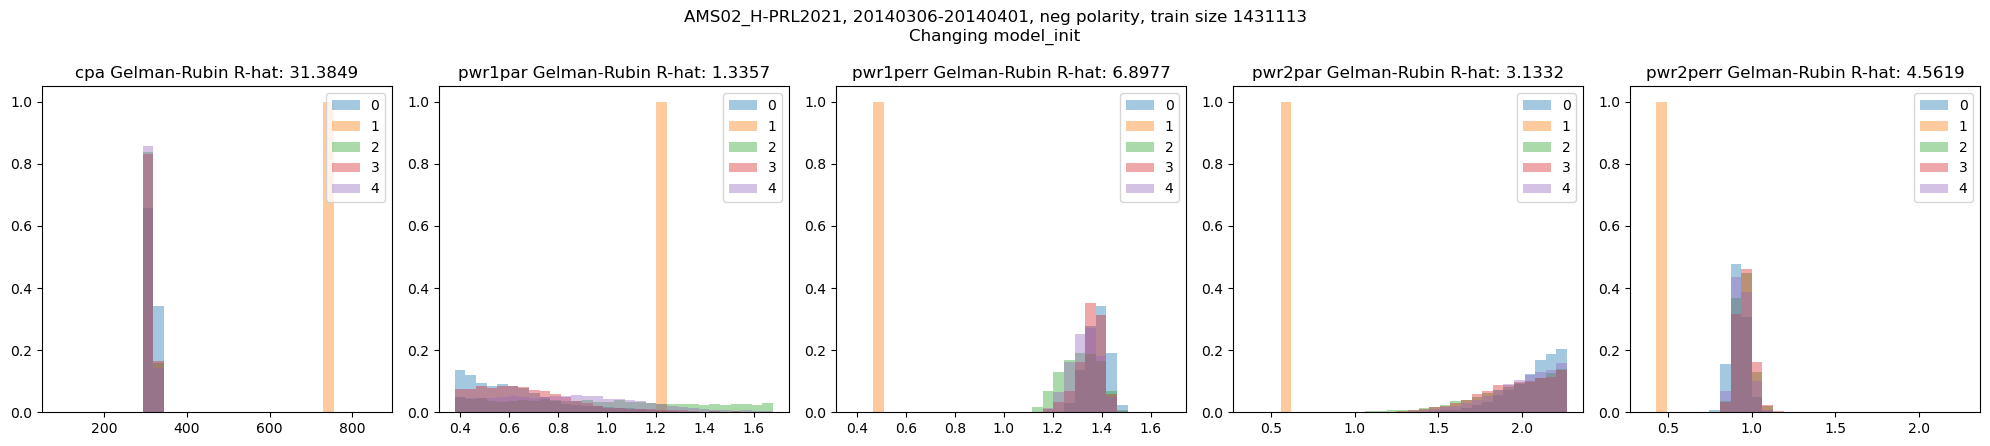

In [7]:
num_bins = 30
metric = 'mae' # 'mae', 'mse', 'kl', or 'wasserstein'

# Let's make a 1 x 5 grid of subplots, where they are the historograms of the samples. We'll plot both hmc_0 and hmc_1 samples in the same grid
fig, axs = plt.subplots(1, 5, figsize=(20, 4.5))
plt.suptitle(f"{exp_name}, {interval}, {polarity} polarity, train size {int(train_size_fraction * 1_788_892)}\nChanging {which_change}")
# Plot the samples
distances = []
for i, param in enumerate(PARAMETERS):
    samples_0 = hmc_0_samples[param].values
    samples_1 = hmc_1_samples[param].values
    samples_2 = hmc_2_samples[param].values
    samples_3 = hmc_3_samples[param].values
    samples_4 = hmc_4_samples[param].values

    # Plot the samples with same bins
    # Use global binning after lab meeting conversation 4/9/2025
    min = PARAMETERS_MIN[i] 
    max = PARAMETERS_MAX[i]

    # Create histograms and plot
    hist_0, bins = np.histogram(samples_0, bins=num_bins, range=(min, max), density=True)
    hist_1, bins = np.histogram(samples_1, bins=num_bins, range=(min, max), density=True)
    hist_2, bins = np.histogram(samples_2, bins=num_bins, range=(min, max), density=True)
    hist_3, bins = np.histogram(samples_3, bins=num_bins, range=(min, max), density=True)
    hist_4, bins = np.histogram(samples_4, bins=num_bins, range=(min, max), density=True)

    # Normalize the histograms
    hist_0 /= hist_0.sum()
    hist_1 /= hist_1.sum()
    hist_2 /= hist_2.sum()
    hist_3 /= hist_3.sum()
    hist_4 /= hist_4.sum()

    # Compute distance as MAE between bins
    distance_01 = get_distance(hist_0, hist_1, metric)
    distance_02 = get_distance(hist_0, hist_2, metric)
    distance_03 = get_distance(hist_0, hist_3, metric)
    distance_04 = get_distance(hist_0, hist_4, metric)

    # Plot the histograms
    axs[i].bar(bins[:-1], hist_0, width=(bins[1]-bins[0]), alpha=0.4, label=f'0')
    axs[i].bar(bins[:-1], hist_1, width=(bins[1]-bins[0]), alpha=0.4, label=f'1')
    axs[i].bar(bins[:-1], hist_2, width=(bins[1]-bins[0]), alpha=0.4, label=f'2')
    axs[i].bar(bins[:-1], hist_3, width=(bins[1]-bins[0]), alpha=0.4, label=f'3')
    axs[i].bar(bins[:-1], hist_4, width=(bins[1]-bins[0]), alpha=0.4, label=f'4')

    # Set the title and labels
    axs[i].set_title(f"{param} Gelman-Rubin R-hat: {rhats[param][0]:.4f}")
    axs[i].legend(loc='upper right')

plt.tight_layout()
plt.savefig(plots_dir / f'sample_histograms_{idx}.png', dpi=300)
plt.show()

## All the train sizes (one time interval)

In [10]:
data_version=['d1', 'd2', 'd3', 'd4', 'd5'] 
model_version=['init1', 'init2', 'init3', 'init4', 'init5'] 
hmc_run = ['hmc1', 'hmc2', 'hmc3', 'hmc4', 'hmc5']
bootstrap=['b0', 'b1'] # 'b0' or 'b1', false or true
which_changes = ["bootstrapped_data", "model_init", "hmc_init"] 
train_fractions = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Parameters (change me!)
idx = 10 # 24 corresponds to 20130221-20130319, the interval in the paper
num_bins = 30
hmc_version='v34_trial5_full'

# Get values
df = index_mcmc_runs(file_version='2023')
df_int = df.iloc[idx:idx+1].copy(deep=True)
interval = df_int.interval.iloc[0]
polarity = df_int.polarity.iloc[0]
exp_name = df_int.experiment_name.iloc[0]

hmc_init_rhats = {}
model_init_rhats = {}
bootstrapped_data_rhats = {}

for param in PARAMETERS:
    hmc_init_rhats[param] = []
    model_init_rhats[param] = []
    bootstrapped_data_rhats[param] = []

for which_change in which_changes:
    if which_change == "bootstrapped_data":
        data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
        data_bootstrap_model_hmc_identifier_1 = f"{data_version[1]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
        data_bootstrap_model_hmc_identifier_2 = f"{data_version[2]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
        data_bootstrap_model_hmc_identifier_3 = f"{data_version[3]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
        data_bootstrap_model_hmc_identifier_4 = f"{data_version[4]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
    elif which_change == "model_init":
        data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
        data_bootstrap_model_hmc_identifier_1 = f"{data_version[0]}_{bootstrap[1]}_{model_version[1]}_{hmc_run[0]}"
        data_bootstrap_model_hmc_identifier_2 = f"{data_version[0]}_{bootstrap[1]}_{model_version[2]}_{hmc_run[0]}"
        data_bootstrap_model_hmc_identifier_3 = f"{data_version[0]}_{bootstrap[1]}_{model_version[3]}_{hmc_run[0]}"
        data_bootstrap_model_hmc_identifier_4 = f"{data_version[0]}_{bootstrap[1]}_{model_version[4]}_{hmc_run[0]}"
    elif which_change == "hmc_init":
        data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
        data_bootstrap_model_hmc_identifier_1 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[1]}"
        data_bootstrap_model_hmc_identifier_2 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[2]}"
        data_bootstrap_model_hmc_identifier_3 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[3]}"
        data_bootstrap_model_hmc_identifier_4 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[4]}"
        
    # Calculate the distance for each parameter and train size
    for i, train_size_fraction in enumerate(train_fractions):
        # Parameters (change me!)
        results_dir_hmc_0 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_0}_{train_size_fraction}/"
        results_dir_hmc_1 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}/"
        results_dir_hmc_2 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_2}_{train_size_fraction}/"
        results_dir_hmc_3 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_3}_{train_size_fraction}/"
        results_dir_hmc_4 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_4}_{train_size_fraction}/"

        # Load the samples from each hmc run
        # They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
        # csv file has no headersd, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
        try:
            hmc_0_samples = pd.read_csv(f'{results_dir_hmc_0}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
            hmc_1_samples = pd.read_csv(f'{results_dir_hmc_1}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
            hmc_2_samples = pd.read_csv(f'{results_dir_hmc_2}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
            hmc_3_samples = pd.read_csv(f'{results_dir_hmc_3}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
            hmc_4_samples = pd.read_csv(f'{results_dir_hmc_4}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')

            hmc_0_samples.columns = PARAMETERS
            hmc_1_samples.columns = PARAMETERS
            hmc_2_samples.columns = PARAMETERS
            hmc_3_samples.columns = PARAMETERS
            hmc_4_samples.columns = PARAMETERS
            
        except FileNotFoundError as e:
            print(f"File not found for train size fraction {train_size_fraction}: {e}")
            continue

        chains_samples = [hmc_0_samples, hmc_1_samples, hmc_2_samples, hmc_3_samples, hmc_4_samples]
        rhats = compute_rhat(chains_samples, params=PARAMETERS, mode='split', thin=1, return_details=False)

        for param, rhat in rhats.items():
            if isinstance(rhat, tuple):
                rhat_value, details = rhat
            else:
                rhat_value = rhat
            print(f"Which change {which_change}, train size fraction {train_size_fraction}, param {param}, R-hat: {rhat_value:.4f}")

            if which_change == "bootstrapped_data":
                bootstrapped_data_rhats[param].append(rhat_value)
            elif which_change == "model_init":
                model_init_rhats[param].append(rhat_value)
            elif which_change == "hmc_init":
                hmc_init_rhats[param].append(rhat_value)

Which change bootstrapped_data, train size fraction 0.0001, param cpa, R-hat: 212.1331
Which change bootstrapped_data, train size fraction 0.0001, param pwr1par, R-hat: 293.3552
Which change bootstrapped_data, train size fraction 0.0001, param pwr1perr, R-hat: 211.8737
Which change bootstrapped_data, train size fraction 0.0001, param pwr2par, R-hat: 174.6306
Which change bootstrapped_data, train size fraction 0.0001, param pwr2perr, R-hat: 244.0115
Which change bootstrapped_data, train size fraction 0.001, param cpa, R-hat: 62.5872
Which change bootstrapped_data, train size fraction 0.001, param pwr1par, R-hat: 117.4001
Which change bootstrapped_data, train size fraction 0.001, param pwr1perr, R-hat: 98.5859
Which change bootstrapped_data, train size fraction 0.001, param pwr2par, R-hat: 124.2322
Which change bootstrapped_data, train size fraction 0.001, param pwr2perr, R-hat: 177.4302
Which change bootstrapped_data, train size fraction 0.01, param cpa, R-hat: 17.5522
Which change boot

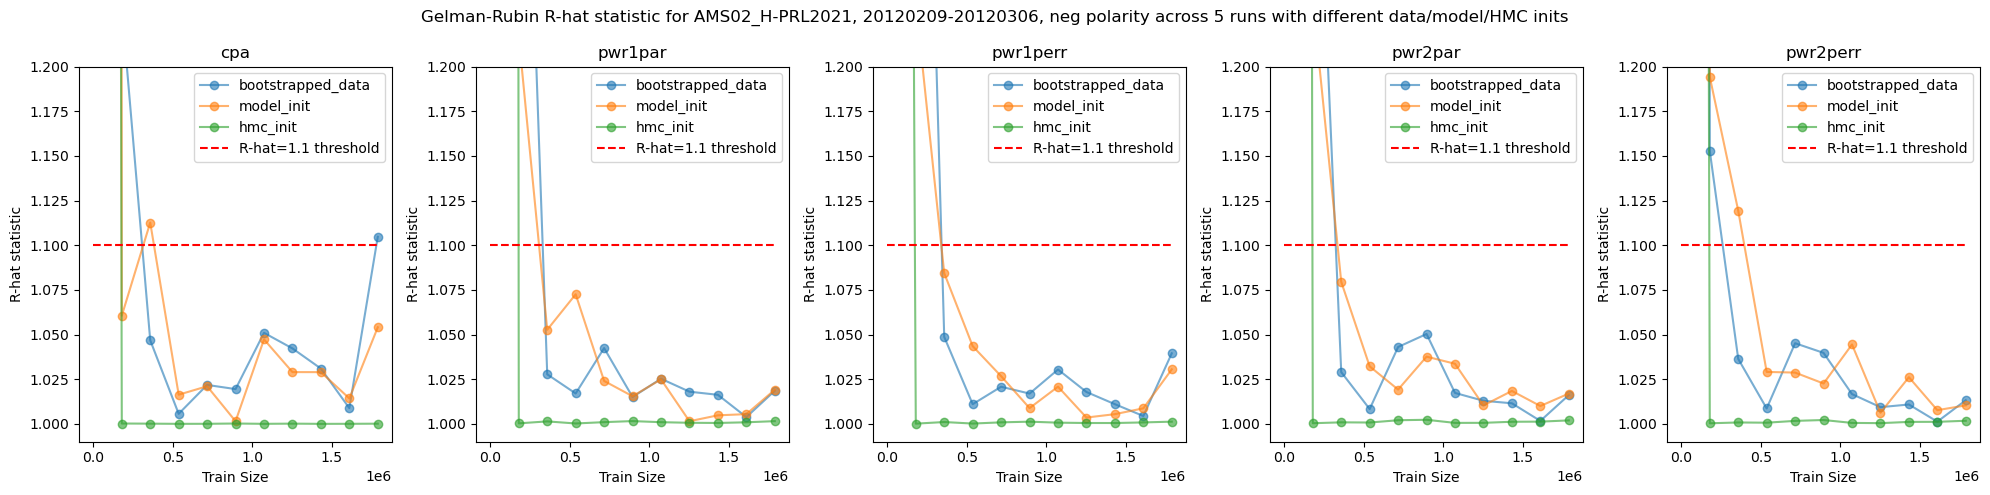

In [11]:
# Let's make a 1 x 5 grid of subplots, where each plot is the distance metric for each parameter over all the train sizes
plt.figure(figsize=(20, 5))
plt.suptitle(f"Gelman-Rubin R-hat statistic for {exp_name}, {interval}, {polarity} polarity across 5 runs with different data/model/HMC inits")
data_train_fractions = np.array(train_fractions) * 1_788_892 # Scale to the number of data points in the full dataset

# Plot the KL divergences
for i, param in enumerate(PARAMETERS):
    plt.subplot(1, 5, i+1)
    plt.plot(data_train_fractions, bootstrapped_data_rhats[param], marker='o', alpha=0.6, label='bootstrapped_data')
    plt.plot(data_train_fractions, model_init_rhats[param], marker='o', alpha=0.6, label='model_init')
    plt.plot(data_train_fractions, hmc_init_rhats[param], marker='o', alpha=0.6, label='hmc_init')
    plt.hlines(y=1.1, xmin=data_train_fractions.min(), xmax=data_train_fractions.max(), color='r', linestyle='--', label='R-hat=1.1 threshold')
    plt.title(param)
    plt.xlabel('Train Size')
    plt.ylabel('R-hat statistic')
    plt.ylim(0.99, 1.2)
    # plt.yscale('log')
    plt.legend()

plt.tight_layout()
plt.savefig(f'../../../results/{hmc_version}/plots/{idx}_rhat_statistic.png', dpi=300)
plt.show()

## All the 132 time intervals (one train size fraction)

In [12]:
data_version=['d1', 'd2', 'd3', 'd4', 'd5'] 
model_version=['init1', 'init2', 'init3', 'init4', 'init5'] 
hmc_run = ['hmc1', 'hmc2', 'hmc3', 'hmc4', 'hmc5']
bootstrap=['b0', 'b1'] # 'b0' or 'b1', false or true
which_changes = ["bootstrapped_data", "model_init", "hmc_init"] 
df_idxs = range(len(df))

# Parameters (change me!)
train_size_fraction = 1.0
num_bins = 30
hmc_version='v34_trial5_full'

# Get values
df = index_mcmc_runs(file_version='2023')

hmc_init_rhats = {}
model_init_rhats = {}
bootstrapped_data_rhats = {}

for param in PARAMETERS:
    hmc_init_rhats[param] = []
    model_init_rhats[param] = []
    bootstrapped_data_rhats[param] = []

for which_change in which_changes:
    if which_change == "bootstrapped_data":
        data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
        data_bootstrap_model_hmc_identifier_1 = f"{data_version[1]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
        data_bootstrap_model_hmc_identifier_2 = f"{data_version[2]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
        data_bootstrap_model_hmc_identifier_3 = f"{data_version[3]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
        data_bootstrap_model_hmc_identifier_4 = f"{data_version[4]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
    elif which_change == "model_init":
        data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
        data_bootstrap_model_hmc_identifier_1 = f"{data_version[0]}_{bootstrap[1]}_{model_version[1]}_{hmc_run[0]}"
        data_bootstrap_model_hmc_identifier_2 = f"{data_version[0]}_{bootstrap[1]}_{model_version[2]}_{hmc_run[0]}"
        data_bootstrap_model_hmc_identifier_3 = f"{data_version[0]}_{bootstrap[1]}_{model_version[3]}_{hmc_run[0]}"
        data_bootstrap_model_hmc_identifier_4 = f"{data_version[0]}_{bootstrap[1]}_{model_version[4]}_{hmc_run[0]}"
    elif which_change == "hmc_init":
        data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
        data_bootstrap_model_hmc_identifier_1 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[1]}"
        data_bootstrap_model_hmc_identifier_2 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[2]}"
        data_bootstrap_model_hmc_identifier_3 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[3]}"
        data_bootstrap_model_hmc_identifier_4 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[4]}"
        
    # Calculate the distance for each parameter and train size
    for i, idx in enumerate(df_idxs):
        df_int = df.iloc[idx:idx+1].copy(deep=True)
        interval = df_int.interval.iloc[0]
        polarity = df_int.polarity.iloc[0]
        exp_name = df_int.experiment_name.iloc[0]

        # Parameters (change me!)
        results_dir_hmc_0 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_0}_{train_size_fraction}/"
        results_dir_hmc_1 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}/"
        results_dir_hmc_2 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_2}_{train_size_fraction}/"
        results_dir_hmc_3 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_3}_{train_size_fraction}/"
        results_dir_hmc_4 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_4}_{train_size_fraction}/"

        # Load the samples from each hmc run
        # They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
        # csv file has no headersd, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
        try:
            hmc_0_samples = pd.read_csv(f'{results_dir_hmc_0}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
            hmc_1_samples = pd.read_csv(f'{results_dir_hmc_1}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
            hmc_2_samples = pd.read_csv(f'{results_dir_hmc_2}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
            hmc_3_samples = pd.read_csv(f'{results_dir_hmc_3}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
            hmc_4_samples = pd.read_csv(f'{results_dir_hmc_4}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')

            hmc_0_samples.columns = PARAMETERS
            hmc_1_samples.columns = PARAMETERS
            hmc_2_samples.columns = PARAMETERS
            hmc_3_samples.columns = PARAMETERS
            hmc_4_samples.columns = PARAMETERS
            
        except FileNotFoundError as e:
            print(f"File not found for df idx {idx}: {e}")
            continue

        chains_samples = [hmc_0_samples, hmc_1_samples, hmc_2_samples, hmc_3_samples, hmc_4_samples]
        rhats = compute_rhat(chains_samples, params=PARAMETERS, mode='split', thin=1, return_details=False)

        for param, rhat in rhats.items():
            if isinstance(rhat, tuple):
                rhat_value, details = rhat
            else:
                rhat_value = rhat
            print(f"Which change {which_change}, df idx {idx}, param {param}, R-hat: {rhat_value:.4f}")

            if which_change == "bootstrapped_data":
                bootstrapped_data_rhats[param].append(rhat_value)
            elif which_change == "model_init":
                model_init_rhats[param].append(rhat_value)
            elif which_change == "hmc_init":
                hmc_init_rhats[param].append(rhat_value)

Which change bootstrapped_data, df idx 0, param cpa, R-hat: 1.0108
Which change bootstrapped_data, df idx 0, param pwr1par, R-hat: 1.0222
Which change bootstrapped_data, df idx 0, param pwr1perr, R-hat: 1.0195
Which change bootstrapped_data, df idx 0, param pwr2par, R-hat: 1.0541
Which change bootstrapped_data, df idx 0, param pwr2perr, R-hat: 1.0377


Which change bootstrapped_data, df idx 1, param cpa, R-hat: 1.0125
Which change bootstrapped_data, df idx 1, param pwr1par, R-hat: 1.0127
Which change bootstrapped_data, df idx 1, param pwr1perr, R-hat: 1.0107
Which change bootstrapped_data, df idx 1, param pwr2par, R-hat: 1.0469
Which change bootstrapped_data, df idx 1, param pwr2perr, R-hat: 1.0316
Which change bootstrapped_data, df idx 2, param cpa, R-hat: 1.0138
Which change bootstrapped_data, df idx 2, param pwr1par, R-hat: 1.0053
Which change bootstrapped_data, df idx 2, param pwr1perr, R-hat: 1.0099
Which change bootstrapped_data, df idx 2, param pwr2par, R-hat: 1.0223
Which change bootstrapped_data, df idx 2, param pwr2perr, R-hat: 1.0116
Which change bootstrapped_data, df idx 3, param cpa, R-hat: 1.0148
Which change bootstrapped_data, df idx 3, param pwr1par, R-hat: 1.0061
Which change bootstrapped_data, df idx 3, param pwr1perr, R-hat: 1.0097
Which change bootstrapped_data, df idx 3, param pwr2par, R-hat: 1.0293
Which change 

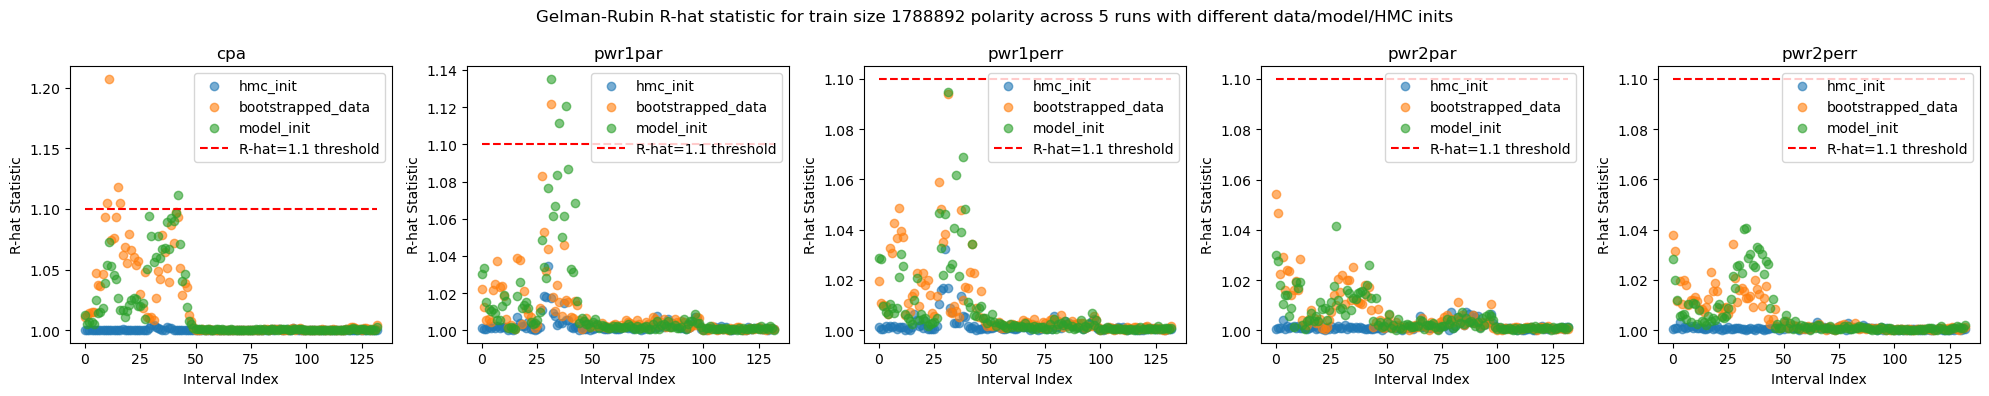

In [15]:
# Let's make a 1 x 5 grid of subplots, where each plot is the kl_divergence for each parameter over all the train sizes
plt.figure(figsize=(20, 4))
plt.suptitle(f"Gelman-Rubin R-hat statistic for train size {int(train_size_fraction * 1_788_892)} polarity across 5 runs with different data/model/HMC inits")

# Plot the R-hat statistics
for i, param in enumerate(PARAMETERS):
    plt.subplot(1, 5, i+1)
    plt.scatter(df_idxs, hmc_init_rhats[param], marker='o', alpha=0.6, label='hmc_init')
    plt.scatter(df_idxs, bootstrapped_data_rhats[param], marker='o', alpha=0.6, label='bootstrapped_data')
    plt.scatter(df_idxs, model_init_rhats[param], marker='o', alpha=0.6, label='model_init')
    plt.hlines(y=1.1, xmin=0, xmax=132, color='r', linestyle='--', label='R-hat=1.1 threshold')
    plt.title(param)
    plt.xlabel('Interval Index')
    plt.ylabel(f'R-hat Statistic')
    plt.legend()
plt.tight_layout()
plt.savefig(f'../../../results/{hmc_version}/plots/{train_size_fraction}_rhat_statistic.png', dpi=300)
plt.show()

In [14]:
# Print the idx where r-hat > 1.1 for each parameter and which change
for which_change, rhats_dict in zip(which_changes, [bootstrapped_data_rhats, model_init_rhats, hmc_init_rhats]):
    print(f"R-hat > 1.1 for which change: {which_change}")
    for param, rhats_list in rhats_dict.items():
        exceeding_idxs = [i for i, rhat in enumerate(rhats_list) if rhat > 1.1]
        exceedings_vals = [rhat for rhat in rhats_list if rhat > 1.1]
        if exceeding_idxs:
            print(f"  Parameter {param} exceeds R-hat > 1.1 at indices: {exceeding_idxs} with values: {exceedings_vals}")
        else:
            print(f"  Parameter {param} does not exceed R-hat > 1.1 at any index.")

R-hat > 1.1 for which change: bootstrapped_data
  Parameter cpa exceeds R-hat > 1.1 at indices: [10, 11, 15, 16] with values: [1.1047069557102538, 1.207298958430102, 1.1180775329208532, 1.1052303414176723]
  Parameter pwr1par exceeds R-hat > 1.1 at indices: [31] with values: [1.121784385355589]
  Parameter pwr1perr does not exceed R-hat > 1.1 at any index.
  Parameter pwr2par does not exceed R-hat > 1.1 at any index.
  Parameter pwr2perr does not exceed R-hat > 1.1 at any index.
R-hat > 1.1 for which change: model_init
  Parameter cpa exceeds R-hat > 1.1 at indices: [42] with values: [1.111565129459389]
  Parameter pwr1par exceeds R-hat > 1.1 at indices: [31, 35, 38] with values: [1.1351997202205903, 1.1116390995112861, 1.1206409992581738]
  Parameter pwr1perr does not exceed R-hat > 1.1 at any index.
  Parameter pwr2par does not exceed R-hat > 1.1 at any index.
  Parameter pwr2perr does not exceed R-hat > 1.1 at any index.
R-hat > 1.1 for which change: hmc_init
  Parameter cpa does no